### Load libraries

In [45]:
import dataclasses
from typing import Dict, List, Optional, Tuple, Union
import warnings

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import mlflow
import mlflow.keras

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from art.data_generators import TensorFlowV2DataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset

### Load data

In [5]:
%%time

MNIST_TRAIN = dataset.get_np_data(name="mnist", split="train")
MNIST_TEST = dataset.get_np_data(name="mnist", split="test")

CIFAR_TRAIN = dataset.get_np_data(name="cifar10", split="train")
CIFAR_TEST = dataset.get_np_data(name="cifar10", split="test")

print(MNIST_TRAIN.xs.shape, MNIST_TRAIN.xs.min(), MNIST_TRAIN.xs.max())
print(MNIST_TEST.xs.shape, MNIST_TEST.xs.min(), MNIST_TEST.xs.max())
print(CIFAR_TRAIN.xs.shape, CIFAR_TRAIN.xs.min(), CIFAR_TRAIN.xs.max())
print(CIFAR_TEST.xs.shape, CIFAR_TEST.xs.min(), CIFAR_TEST.xs.max())

(60000, 784) 0.0 1.0
(10000, 784) 0.0 1.0
(50000, 3072) 0.0 1.0
(10000, 3072) 0.0 1.0
CPU times: user 21.6 s, sys: 18.2 s, total: 39.8 s
Wall time: 7.09 s


[4 1 0 7 8 1 2 7 1 6]


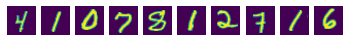

[2 0 4 8 7 6 0 6 3 1]


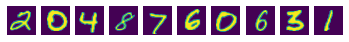

[7 8 4 4 6 5 2 9 6 6]


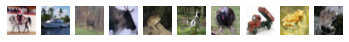

[7 0 6 9 5 1 7 0 3 2]


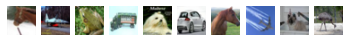

In [6]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)
dataset.plot_images(CIFAR_TRAIN, channels=3)
dataset.plot_images(CIFAR_TEST, channels=3)

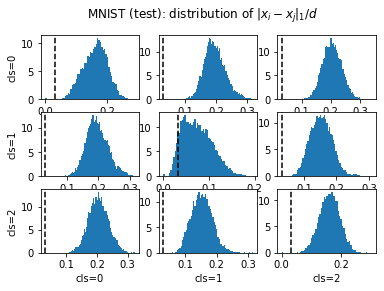

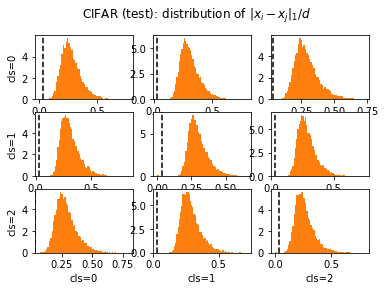

In [7]:
def plot_avg_dists(ds: dataset.Dataset, num_samples=1000, n_cls=2, eps=8/255, **plt_kwargs):
    dists = np.zeros((n_cls, n_cls, num_samples))
    for i in range(n_cls):
        for j in range(n_cls):
            xs_i = ds.xs[ds.ys == i]
            xs_j = ds.xs[ds.ys == j]
            
            idxs_i = np.random.randint(0, xs_i.shape[0], size=num_samples)
            idxs_j = np.random.randint(0, xs_j.shape[0], size=num_samples)
            
            diffs = xs_i[idxs_i] - xs_j[idxs_j]
            dists[i, j] = np.linalg.norm(diffs, ord=1, axis=-1) / diffs.shape[-1]
    
    for i in range(n_cls):
        for j in range(n_cls):
            plt.subplot(n_cls, n_cls, 1 + n_cls * i + j)
            plt.hist(dists[i, j], **plt_kwargs)
            if j == 0:
                plt.ylabel(f"cls={i}")
            if i == n_cls-1:
                plt.xlabel(f"cls={j}")
            plt.axvline(eps, color="black", linestyle="--")
                
plt.suptitle("MNIST (test): distribution of $\|x_i - x_j\|_1 / d$")
plot_avg_dists(MNIST_TEST, num_samples=10**4, bins=64, n_cls=3, density=True)
plt.show();

plt.suptitle("CIFAR (test): distribution of $\|x_i - x_j\|_1 / d$")
plot_avg_dists(CIFAR_TEST, num_samples=10**4, bins=64, n_cls=3, density=True, color="tab:orange")
plt.show();

### Experiment setup

In [8]:
def untensor_dict(d: Dict) -> Dict:
    return {
        k: float(v) if isinstance(v, tf.Tensor) else v
        for k, v in d.items()
    }

def out_to_dict(out: Tuple, model: keras.Model, prefix: str) -> Dict:
    return untensor_dict({
        f"{prefix}_{k}" : v
        for k, v
        in zip(model.metrics_names, out)
    })

def fmt_dict(d: Dict) -> str:
    dd = {
        k: f"{v : .4f}" if isinstance(v, float) else v
        for k, v in d.items()
    }
    return str(dd)

def mlflow_log_np(a: np.ndarray, name: str):
    """name should not include .npy"""
    np.save(f"tmp-artifacts/{name}.npy", a)
    mlflow.log_artifact(f"tmp-artifacts/{name}.npy")

In [90]:
@dataclasses.dataclass
class ExperimentParams:
    ds_train: dataset.Dataset  # not one hot
    ds_test: dataset.Dataset   # not one hot
    num_fourier_features: int
    kernel_scale: float
    kernel_type: str
    train_epochs: int
    adv_ratio: float  # in [0, 1]; 0 = nat. training; 1 = full adv. training
    use_pgd: bool
    attack_norm: Union[float, int]
    attack_eps: float
    attack_eps_step: float
    attack_iters: int
    num_eval_per_epoch: int  # How many samples to use during evaluation
    batch_size: int
    learning_rate: int
    seed: int = 42
    
    def __post_init__(self):
        assert not self.ds_train.one_hot
        assert not self.ds_test.one_hot
    
    def to_mlflow_dict(self) -> Dict:
        ret = dataclasses.asdict(self)
        
        del ret["ds_train"]
        del ret["ds_test"]
        
        ret["ds_train_name"] = self.ds_train.name
        ret["ds_test_name"] = self.ds_test.name
        
        return ret
    
    
def run_experiment(params: ExperimentParams, print_every: Optional[int] = None):
    """
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    mlflow.log_params(params.to_mlflow_dict())
    np.random.seed(params.seed)
    tf.random.set_seed(params.seed)
    
    DS_TRAIN = params.ds_train.to_one_hot()
    DS_TEST = params.ds_test.to_one_hot()
    DATA_SHAPE = DS_TRAIN.xs[0].shape
    
    class ExperimentCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch: int, logs: Dict):
            logs = untensor_dict(logs)
            if epoch % print_every == 0:
                print(f"Epoch {epoch} finished; Evaling...", end=" ")
            
            ds_sub_train = DS_TRAIN.subsample(params.num_eval_per_epoch)
            ds_sub_test = DS_TEST.subsample(params.num_eval_per_epoch)
            
            xs_sub_train_pgd = art_pgd_attack.generate(x=ds_sub_train.xs, y=ds_sub_train.ys)
            xs_sub_test_pgd = art_pgd_attack.generate(x=ds_sub_test.xs, y=ds_sub_test.ys)
            
            sub_train_nat_out = model.evaluate(ds_sub_train.xs, ds_sub_train.ys, verbose=0)
            sub_test_nat_out = model.evaluate(ds_sub_test.xs, ds_sub_test.ys, verbose=0)
            
            sub_train_pgd_out = model.evaluate(xs_sub_train_pgd, ds_sub_train.ys, verbose=0)
            sub_test_pgd_out = model.evaluate(xs_sub_test_pgd, ds_sub_test.ys, verbose=0)
            
            mlflow.log_metrics(out_to_dict(prefix="sub_train_nat", out=sub_train_nat_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_train_pgd", out=sub_train_pgd_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_test_nat", out=sub_test_nat_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_test_pgd", out=sub_test_pgd_out, model=model))
            mlflow.log_metrics(logs)
            
            if epoch % print_every == 0:
                print(fmt_dict(logs))
                print(fmt_dict(out_to_dict(prefix="sub_train_pgd", out=sub_train_pgd_out, model=model)))
    
    def kernel_f(n):
        """
        Per https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/RandomFourierFeatures
        """
        if params.kernel_type.lower() == "gaussian":
            return np.exp(- n ** 2 / (2 * params.kernel_scale ** 2))
        elif params.kernel_type.lower() == "laplacian":
            return np.exp(- n / params.kernel_scale)
        else:
            raise NotImplementedError
        
    def delta(eps):
        return np.sqrt(2 * (kernel_f(0) - kernel_f(eps)))
    
    
    model : keras.Model = keras.Sequential([
        keras.layers.InputLayer(
            input_shape=DATA_SHAPE,
        ),
        layers.experimental.RandomFourierFeatures(
            output_dim=params.num_fourier_features,
            scale=params.kernel_scale,
            kernel_initializer=params.kernel_type,
            trainable=False,
        ),
        layers.experimental.preprocessing.Rescaling(
            scale=np.sqrt(2 / np.prod(DATA_SHAPE)),
            trainable=False,
        ),
        layers.Dense(units=10),
    ])
    
    def categorical_hinge(y_true, y_pred):
        """
        Corrects implementation bug in keras.losses.categorical_hinge.
        See https://github.com/keras-team/keras/issues/8083
        """
        y_pred = 1 + y_pred - K.min(y_pred, axis=-1, keepdims=True)
        return keras.losses.categorical_hinge(y_true, y_pred)
    
    def categorical_hinge_robust_ub(y_true, y_pred):        
        W = model.layers[-1].kernel  # shape: (num_fourier_features, num_classes)
        W_norms = tf.reshape(tf.norm(W, ord=2, axis=0), (1, -1))  # shape(batch_size, num_classes)
        
        y_pred_adv = (
            y_pred
          + delta(params.attack_eps)
              * (y_true * -W_norms + (1 - y_true) * W_norms)
        )
        
        return categorical_hinge(y_true, y_pred_adv)
    
    def rob_ub_loss(y_true, y_pred):
        return (
            params.adv_ratio * categorical_hinge_robust_ub(y_true, y_pred)
          + (1 - params.adv_ratio) * categorical_hinge(y_true, y_pred)
        )
    
    def attack_loss(y_true, y_pred):
        y_pred = 1 + y_pred - K.min(y_pred, axis=-1, keepdims=True)
        
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1 - y_true) * y_pred, axis=-1)
        
        return neg - pos
        
    model.compile(
        loss=categorical_hinge if params.use_pgd else rob_ub_loss,
        optimizer=keras.optimizers.Adam(learning_rate=params.learning_rate),
        #optimizer=keras.optimizers.SGD(
        #    learning_rate=params.learning_rate,
        #    momentum=0.9,
        #),
        metrics=["accuracy"]
    )
    
    # Wrapper around tf.keras.Model.train_step
    # Used for compatibility with art.estimators.classification.TensorFlowV2Classifier
    _sample_count = 0
    art_pgd_attack = None # Forward declaration. Hacky...
    def train_step(model, images, labels):
        nonlocal _sample_count
        nonlocal art_pgd_attack
        
        logs = model.train_step((images, labels))
        
        old_sample_count = _sample_count
        _sample_count += images.shape[0]
        
        old_epoch = old_sample_count // DS_TRAIN.xs.shape[0]
        cur_epoch = _sample_count // DS_TRAIN.xs.shape[0]
        
        if old_epoch < cur_epoch:
            ExperimentCallback().on_epoch_end(epoch=old_epoch, logs=logs)
            model.reset_metrics()
            

    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=DATA_SHAPE,
        nb_classes=DS_TRAIN.num_classes,
        clip_values=(0, 1),
        loss_object=attack_loss,
        train_step=train_step,
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=params.attack_norm,
        eps=params.attack_eps,
        eps_step=params.attack_eps_step,
        max_iter=params.attack_iters,
        batch_size=params.batch_size,
        verbose=False,
    )
    
    try: # Catch keyboard interrupt so we can exit training early
        if params.use_pgd and params.adv_ratio > 0:
            print(f"PGD training with ratio {params.adv_ratio} ...")
            adv_trainer = AdversarialTrainer(
                art_model,
                attacks=art_pgd_attack,
                ratio=params.adv_ratio,
            )
            adv_trainer.fit(
                x=DS_TRAIN.xs, y=DS_TRAIN.ys,
                batch_size=params.batch_size,
                nb_epochs=params.train_epochs,
            )
        else:
            if params.adv_ratio > 0:
                print(f"Rob. UB training with ratio {params.adv_ratio} ...")
            else:
                print(f"Natural training...")

            model.fit(
                DS_TRAIN.xs,
                DS_TRAIN.ys,
                batch_size=params.batch_size,
                epochs=params.train_epochs,
                verbose=0,
                callbacks=[ExperimentCallback()],
            )
    except KeyboardInterrupt:
        pass

    model.trainable = False
    mlflow.keras.log_model(model, "model")
    
    xs_test_pgd = art_pgd_attack.generate(x=DS_TEST.xs, y=DS_TEST.ys)
    mlflow_log_np(xs_test_pgd, "xs_test_pgd")
    
    test_nat_out = model.evaluate(DS_TEST.xs, DS_TEST.ys)
    test_pgd_out = model.evaluate(xs_test_pgd, DS_TEST.ys)
    
    mlflow.log_metrics(out_to_dict(prefix="test_nat", out=test_nat_out, model=model))
    mlflow.log_metrics(out_to_dict(prefix="test_pgd", out=test_pgd_out, model=model))
    
    preds_test_pgd = model.predict(x=xs_test_pgd, batch_size=params.batch_size).argmax(axis=-1)
    mlflow_log_np(preds_test_pgd, "preds_test_pgd")
    
    mlflow_log_np(params.ds_test.xs.astype(np.float16), "xs_test")
    mlflow_log_np(params.ds_test.ys, "ys_test")
    
    return dict(
        model=model,
        ds_test=params.ds_test,
        xs_test_pgd=xs_test_pgd,
        preds_test_pgd=preds_test_pgd,
    )

# Run experiments

Have a hard time overfitting with small kernel_scale and crossentropy loss.
Hinge loss also did not work.

But what did work, was setting kernel_scale very small and training just on natural loss.
In this case it is very easy to get high natural accuracy, which also guarantees high adversarial accuracy.

It seems adversarial training is very hard to converge on.

In [91]:
EXP_PARAMS = ExperimentParams(
    ds_train=CIFAR_TRAIN.prefix(32),
    ds_test=CIFAR_TEST.prefix(32),
    num_fourier_features=4096,
    kernel_scale=100,
    kernel_type="gaussian",
    train_epochs=300,
    adv_ratio=1.0,
    use_pgd=True,
    attack_norm=np.inf,
    attack_eps=8.0/255,
    attack_eps_step=8.0/255/10,
    attack_iters=20,
    num_eval_per_epoch=32,  # How many samples to use during evaluation
    batch_size=32,
    learning_rate=3e-3,
    seed=42,
)

with mlflow.start_run() as _:
    res = run_experiment(EXP_PARAMS, print_every=5)

PGD training with ratio 1.0 ...


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0 finished; Evaling... {'loss': ' 1.0658', 'accuracy': ' 0.0625'}
{'sub_train_pgd_loss': ' 1.1463', 'sub_train_pgd_accuracy': ' 0.0000'}
Epoch 5 finished; Evaling... {'loss': ' 1.3885', 'accuracy': ' 0.1562'}
{'sub_train_pgd_loss': ' 1.4648', 'sub_train_pgd_accuracy': ' 0.1562'}
Epoch 10 finished; Evaling... {'loss': ' 1.2612', 'accuracy': ' 0.1250'}
{'sub_train_pgd_loss': ' 1.2632', 'sub_train_pgd_accuracy': ' 0.0938'}
Epoch 15 finished; Evaling... {'loss': ' 1.1977', 'accuracy': ' 0.1875'}
{'sub_train_pgd_loss': ' 1.2273', 'sub_train_pgd_accuracy': ' 0.1875'}
Epoch 20 finished; Evaling... {'loss': ' 1.1154', 'accuracy': ' 0.1562'}
{'sub_train_pgd_loss': ' 1.1030', 'sub_train_pgd_accuracy': ' 0.0938'}
Epoch 25 finished; Evaling... {'loss': ' 1.1197', 'accuracy': ' 0.1875'}
{'sub_train_pgd_loss': ' 1.1327', 'sub_train_pgd_accuracy': ' 0.2500'}
Epoch 30 finished; Evaling... {'loss': ' 1.0966', 'accuracy': ' 0.2500'}
{'sub_train_pgd_loss': ' 1.0987', 'sub_train_pgd_accuracy': ' 0.1

INFO:tensorflow:Assets written to: /tmp/tmpffonxtnw/model/data/model/assets


1/1 [==============================] - 0s 15ms/step - loss: 1.2070 - accuracy: 0.2188


mx_pix_diff:  8.0000 / 255
mx_l2_diff:  1.7380

[7 0 6 9 5 1 7 0 3 2]


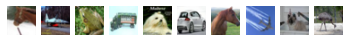

[9 5 4 9 6 8 9 8 9 0]


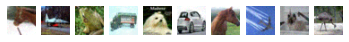

In [92]:
mx_pix_diff = np.abs(res["xs_test_pgd"] - res["ds_test"].xs).max() * 255
print(f"mx_pix_diff: {mx_pix_diff : .4f} / 255")

mx_l2_diff = np.linalg.norm(res["xs_test_pgd"] - res["ds_test"].xs, ord=2, axis=-1).max()
print(f"mx_l2_diff: {mx_l2_diff : .4f}\n")

dataset.plot_images(res["ds_test"], channels=3)

dataset.plot_images(
    dataset.Dataset(
        xs=res["xs_test_pgd"],
        ys=res["preds_test_pgd"],
        one_hot=False,
        num_classes=10,
    ), channels=3
)